In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import json
from sklearn.model_selection import train_test_split
import warnings
import os
from PIL import Image
import matplotlib.pyplot as plt

from utils.dataloader import *
from models import Create_nets

In [2]:
def plot_allbars(df, args):
    '''
    Plots all the bars and ratios from a dataset
    '''
    df_filtered = df[df['categories'].isin(['Train', 'Test'])]

    fig, ax = plt.subplots(figsize=(20, 8))
    unique_classes = df_filtered['class'].unique()
    x_positions = range(len(unique_classes))
    positions = {'Train': -0.2, 'Test': 0.2}
    
    # Create a mapping from class labels to their positions
    class_to_pos = {cls: pos for cls, pos in zip(unique_classes, x_positions)}

    # Plot stacked bar chart with specified colors
    for idx, category in enumerate(df_filtered['categories'].unique()):
        print(idx, category)
        grp = df_filtered[df_filtered['categories'] == category]
        if category == 'Train':
            color_good = 'dodgerblue'
            color_anomaly = 'orange'
        else:
            color_good = 'darkblue'
            color_anomaly = 'red'
        
        bar_positions = [class_to_pos[cls] + positions[category] for cls in grp['class']]
        
        bars_good = ax.bar(bar_positions, grp['good_images'], width=0.4, color=color_good, label=f'Good Images - {category}' if idx == 0 else "", align='center')
        bars_anomalies = ax.bar(bar_positions, grp['anomalies'], bottom=grp['good_images'], width=0.4, color=color_anomaly, label=f'Anomalies - {category}' if idx == 0 else "", align='center')
        
        # Add ratios on top of the bars
        for bar, ratio in zip(bars_anomalies, grp['ratios']):
            height = bar.get_height() + bar.get_y()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{ratio:.2f}', ha='center', va='bottom')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{args.data_set} - Contamination Rate: {args.contamination_rate}')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(unique_classes)
    ax.legend()

    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='dodgerblue', lw=4, label='Good Train'),
        Line2D([0], [0], color='darkblue', lw=4, label='Good Test'),
        Line2D([0], [0], color='orange', lw=4, label='Anomaly Train'),
        Line2D([0], [0], color='red', lw=4, label='Anomaly Test')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

    plt.show()

### Dataset

In [3]:
class ImageDataset_mvtec(Dataset):
    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):
        
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        
        self.resize_transform_loco = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if mode == 'train':
            self.files = train_paths
        elif mode == 'test':
            self.files = test_paths
            
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask
    
    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(filename)
        img = img.convert('RGB')
        

        if self.args.mode=='mvtec_loco':
            img = self.resize_transform_loco(img)       

        
        if self.mode == 'train':
            img = self.transform_train(img)            
            return filename, img
        
        elif self.mode == 'test':
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            
            if 'good' in filename:    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 0
            else:   
                # different ground truth schema for mvtec_loco
                if self.args.mode=='mvtec_loco':
                    ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".png", "/000.png"))                        
                if self.args.mode=='mvtec':
                    ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".png", "_mask.png"))
                
                ground_truth = self.resize_transform_loco(ground_truth)  
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 1
            
    def __len__(self):
        return len(self.files)


In [4]:
class ImageDataset_beantec(Dataset):
    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):
        
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        
        self.resize_transform_bean = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if mode == 'train':
            self.files = train_paths
        elif mode == 'test':
            self.files = test_paths
            
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask
    
    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(filename)
        img = img.convert('RGB')
        img = self.resize_transform_bean(img)

        
        if self.mode == 'train':
            img = self.transform_train(img)            
            return filename, img
        
        elif self.mode == 'test':
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            
            if 'ok' in os.path.split(filename)[0].split(os.sep):    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 0
            else:   
 
                ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".bmp", ".png"))
                
                ground_truth = self.resize_transform_bean(ground_truth)  
                
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 1
            
    def __len__(self):
        return len(self.files)

In [5]:
class ImageDataset_visa(Dataset):
    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):
        
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        
        self.resize_transform_visa = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if mode == 'train':
            self.files = train_paths
        elif mode == 'test':
            self.files = test_paths
            
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask
    
    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(filename)
        img = img.convert('RGB')
        img = self.resize_transform_visa(img)

        if self.mode == 'train':
            img = self.transform_train(img)            
            return filename, img
        
        elif self.mode == 'test':
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            if 'Normal' in os.path.split(filename)[0].split(os.sep):    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                return filename, img, ground_truth, 0
            else:   
                ground_truth = Image.open(filename.replace("Images", "Masks").replace(".JPG", ".png"))
                ground_truth = self.resize_transform_visa(ground_truth)  
                img, ground_truth = transform_test(img, ground_truth) 
                
                ground_truth=(ground_truth > 0).float()
                # TODO check for mask if resized correctly
                return filename, img, ground_truth, 1
            
    def __len__(self):
        return len(self.files) 


### get paths for the sets

In [6]:
def get_paths_mvtec_loco(args,verbose=True):
    

    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    DATA_PATH=args.data_root
    
    NORMAL_PATH = os.path.join(DATA_PATH, f'{category}/train/good')
    VALIDATION_PATH = os.path.join(DATA_PATH, f'{category}/validation/good')
    ANOMALY_PATH = os.path.join(DATA_PATH , f'{category}/test')
    
    file_path = []
    for root, dirs, files in os.walk(ANOMALY_PATH):
        for file in files:
            file_path.append( os.path.join(root, file))
        
    anomaly_images_test=[item for item in file_path if "good" not in item]
    good_images_test=[item for item in file_path if "good" in item]
    
    normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
    validation_images=[os.path.join(VALIDATION_PATH,item) for item in os.listdir(VALIDATION_PATH)]

    
    n_samples = int((len(normal_images)+len(validation_images))*args.contamination_rate)
    valid_train_ratio=float(len(validation_images)/(len(normal_images)+len(validation_images)))
    
    
    
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test,anomaly_categories[category], n_samples, args.seed)

    if validation:
        warnings.warn(f"Vaidation split is set to {validation_split}, but the dataset is already split into train and validation sets by publisher. Ignoring validation split ratio.")
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=valid_train_ratio, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []

    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
        
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [7]:
def get_paths_mvtec(args,verbose=True):
    
    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    DATA_PATH=args.data_root
    
    
    NORMAL_PATH = os.path.join(DATA_PATH, f'{category}/train/good')
    ANOMALY_PATH = os.path.join(DATA_PATH , f'{category}/test')
    
        
    normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
    file_path = []
    for root, _, files in os.walk(ANOMALY_PATH):
        for file in files:
            file_path.append( os.path.join(root, file))
        
    anomaly_images_test=[item for item in file_path if "good" not in item]
    good_images_test=[item for item in file_path if "good" in item]
    

    ## TODO changes fixed seed
    n_samples = int(len(normal_images)*args.contamination_rate)
    
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test, anomaly_categories[category], n_samples, args.seed)

    if validation_split > 0:
        if validation!= True:
            raise ValueError('validation_split is set to > 0 but use_validation is set to False')
        normal_images,validation_images = train_test_split(normal_images, test_size=validation_split, random_state=args.seed)
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=validation_split, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []
        validation_images = []

    print("debug","got to load the data")
    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
    
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [8]:
def get_paths_beantec(args,verbose=True):
    
    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    DATA_PATH=args.data_root
    
    NORMAL_PATH = os.path.join(DATA_PATH, f'{category}/train/ok')
    ANOMALY_PATH = os.path.join(DATA_PATH , f'{category}/test')
    
        
        
    ## TODO for class "03" only half the paths
    if category=="03":
        normal_images=args.dataset_parameters["reduced_train_paths"]["03"]
        
    else:   
        normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
    
    
    
    file_path = []
    for root, _, files in os.walk(ANOMALY_PATH):
        for file in files:
            file_path.append( os.path.join(root, file))
        
    anomaly_images_test=[item for item in file_path if "ok" not in os.path.split(item)[0].split(os.sep)]
    good_images_test=[item for item in file_path if "ok" in os.path.split(item)[0].split(os.sep)]
    

    
    n_samples = int(len(normal_images)*args.contamination_rate)
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test, anomaly_categories[category], n_samples, args.seed)

    if validation_split > 0:
        if validation!= True:
            raise ValueError('validation_split is set to > 0 but use_validation is set to False')
        normal_images,validation_images = train_test_split(normal_images, test_size=validation_split, random_state=args.seed)
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=validation_split, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []
        validation_images = []
        
    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
    
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [9]:
def get_paths_visa(args,verbose=True):
    
    DATA_PATH=args.data_root
    
    
    df = pd.read_csv(os.path.join(DATA_PATH,'split_csv/1cls.csv')) # use split 1
    
    
    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    
    

    
        
    category=args.data_category

    df_cat=df[df['object']==category]
    df_test=df_cat[df_cat['split']=='test']

    normal_train=df_cat[df_cat['split']=='train']['image'].values.tolist()
    normal_test=df_test[df_test['label']=='normal']['image'].values.tolist()
    anomaly_test=df_test[df_test['label']=='anomaly']['image'].values.tolist()
    
    normal_images=[os.path.join(DATA_PATH,item) for item in normal_train]
    good_images_test=[os.path.join(DATA_PATH,item) for item in normal_test]
    anomaly_images_test=[os.path.join(DATA_PATH,item) for item in anomaly_test]
    
    
    n_samples = int(len(normal_images)*args.contamination_rate)
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test, anomaly_categories[category], n_samples, args.test_seed)

    if validation_split > 0:
        if validation!= True:
            raise ValueError('validation_split is set to > 0 but use_validation is set to False')
        normal_images,validation_images = train_test_split(normal_images, test_size=validation_split, random_state=args.seed)
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=validation_split, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []
        validation_images = []
        
    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
    
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [10]:
def get_dataloader(args):

    if args.mode == 'mvtec' or args.mode == 'mvtec_loco':
        
        EXPERIMENT_LOG_PATH = os.path.join(args.results_dir,args.data_set ,
                                    f'contamination_{int(args.contamination_rate*100)}',
                                    f'{args.exp_name}-{args.data_category}')
        
        if os.path.exists(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json")) and not args.development:
            with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "r") as file:
                experiment_paths = json.load(file)
                print("sucessfully loaded experiment paths")   
                
        else:    
            if args.mode == 'mvtec':    
                normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
                
            if args.mode == 'mvtec_loco':
                normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec_loco(args,verbose=True)

            # sample from train paths if less trainming data should be used
            train_paths = normal_images + sampled_anomalies_for_train
            train_paths=random.sample(train_paths,int(len(train_paths)*args.data_ratio))
            left_out_train_paths = list(set(normal_images + sampled_anomalies_for_train) - set(train_paths))
            valid_paths = validation_images + sampled_anomalies_for_val
            test_paths = good_images_test + remaining_anomalies_test
            experiment_paths={'train':train_paths,'test':test_paths,'valid':valid_paths,'leftout_train_paths':left_out_train_paths,'contamination_rate':args.contamination_rate,'seed':args.seed}
            
            if not args.development:
                os.makedirs(EXPERIMENT_LOG_PATH, exist_ok=True)
                with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "w") as file:
                    json.dump(experiment_paths, file)
        
        
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        train_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None),
                                                        batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
        if len(experiment_paths['valid']) > 0:
            valid_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
        else:
            valid_dataloader = None
        test_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)

    if args.mode == 'beantec':
        
        EXPERIMENT_LOG_PATH = os.path.join(args.results_dir,args.data_set ,
                                    f'contamination_{int(args.contamination_rate*100)}',
                                    f'{args.exp_name}-{args.data_category}')
        
        if os.path.exists(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json")) and not args.development:
            with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "r") as file:
                experiment_paths = json.load(file)     
                
        else:    
            normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_beantec(args,verbose=True)    
            
            # sample from train paths if less trainming data should be used
            train_paths = normal_images + sampled_anomalies_for_train
            train_paths=random.sample(train_paths,int(len(train_paths)*args.data_ratio))
            left_out_train_paths = list(set(normal_images + sampled_anomalies_for_train) - set(train_paths))
            valid_paths = validation_images + sampled_anomalies_for_val
            test_paths = good_images_test + remaining_anomalies_test
            experiment_paths={'train':train_paths,'test':test_paths,'valid':valid_paths,'leftout_train_paths':left_out_train_paths,'contamination_rate':args.contamination_rate,'seed':args.seed}
            
            if not args.development:
                os.makedirs(EXPERIMENT_LOG_PATH, exist_ok=True)
                with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "w") as file:
                    json.dump(experiment_paths, file)
        
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        train_dataloader = DataLoader(ImageDataset_beantec(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None),
                                                        batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
        if len(experiment_paths['valid']) > 0:
            valid_dataloader = DataLoader(ImageDataset_beantec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
        else:
            valid_dataloader = None
        test_dataloader = DataLoader(ImageDataset_beantec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),
                                                        batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)

    if args.mode == 'visa':
        
        EXPERIMENT_LOG_PATH = os.path.join(args.results_dir,args.data_set ,
                                    f'contamination_{int(args.contamination_rate*100)}',
                                    f'{args.exp_name}-{args.data_category}')
        
        if os.path.exists(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json")) and not args.development:
            with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "r") as file:
                experiment_paths = json.load(file)     
                
        else:    
            normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_visa(args,verbose=True)    
            
            # sample from train paths if less trainming data should be used
            train_paths = normal_images + sampled_anomalies_for_train
            train_paths=random.sample(train_paths,int(len(train_paths)*args.data_ratio))
            left_out_train_paths = list(set(normal_images + sampled_anomalies_for_train) - set(train_paths))
            valid_paths = validation_images + sampled_anomalies_for_val
            test_paths = good_images_test + remaining_anomalies_test
            experiment_paths={'train':train_paths,'test':test_paths,'valid':valid_paths,'leftout_train_paths':left_out_train_paths,'contamination_rate':args.contamination_rate,'seed':args.seed}
            
            
            if not args.development:
                os.makedirs(EXPERIMENT_LOG_PATH, exist_ok=True)
                with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "w") as file:
                    json.dump(experiment_paths, file)
        
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        train_dataloader = DataLoader(ImageDataset_visa(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None),
                                                        batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
        if len(experiment_paths['valid']) > 0:
            valid_dataloader = DataLoader(ImageDataset_visa(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
        else:
            valid_dataloader = None
            
        test_dataloader = DataLoader(ImageDataset_visa(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),
                                                        batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
    
    
    
    if args.mode == 'utrad_mvtec':
        
        if args.contamination_rate != 0.0:
            raise ValueError("Contamination rate should be 0.0 for clean original implementation")
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        
        train_dataloader = DataLoader(ImageDataset(args,DATA_PATH, mode='train'),
                                                    batch_size=args.batch_size, shuffle=True, num_workers=args.n_cpu, drop_last=False)
        test_dataloader = DataLoader(ImageDataset(args, DATA_PATH, mode='test'),
                            batch_size=args.batch_size, shuffle=False, num_workers=1, drop_last=False)


    return train_dataloader,valid_dataloader, test_dataloader

MVTEC


In [11]:
category='screw'

anomaly_categories={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]}


#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self, category='screw'):
        self.exp_name = "DEV_DATALOADER"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = False
        self.test_seed = 400
        self.data_ratio = 0.5
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.data_category = category
        self.batch_size = 20
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'mvtec'
        self.mode = 'mvtec'
        self.results_dir = 'results'
        self.development = False
        
        
args = TrainOptions()
#torch.manual_seed(args.seed)
import time
import numpy as np


if not args.fixed_seed_bool:
    args.test_seed = int(time.time())
    args.seed = int(time.time())

torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)    
    

try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)
dataiter = iter(train_dataloader)



try:
    images, _ = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")


sucessfully loaded experiment paths
('/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/297.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/115.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/185.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/test/thread_side/022.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/189.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/126.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/021.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/239.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/172.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/150.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/216.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/

debug got to load the data
category: bottle, normals train:  209, anomalies test: 63, normal test: 20
anomalies test total:     {'broken_large': 20, 'broken_small': 22, 'contamination': 21}
anomalies test sampled:   {'broken_large': 6, 'broken_small': 6, 'contamination': 6}
anomalies test remaining: {'broken_large': 14, 'broken_small': 16, 'contamination': 15}
debug got to load the data
category: cable, normals train:  224, anomalies test: 92, normal test: 58
anomalies test total:     {'bent_wire': 13, 'cable_swap': 12, 'combined': 11, 'cut_inner_insulation': 14, 'cut_outer_insulation': 10, 'missing_cable': 12, 'missing_wire': 10, 'poke_insulation': 10}
anomalies test sampled:   {'bent_wire': 3, 'cable_swap': 2, 'combined': 2, 'cut_inner_insulation': 3, 'cut_outer_insulation': 2, 'missing_cable': 2, 'missing_wire': 2, 'poke_insulation': 2}
anomalies test remaining: {'bent_wire': 10, 'cable_swap': 10, 'combined': 9, 'cut_inner_insulation': 11, 'cut_outer_insulation': 8, 'missing_cable':

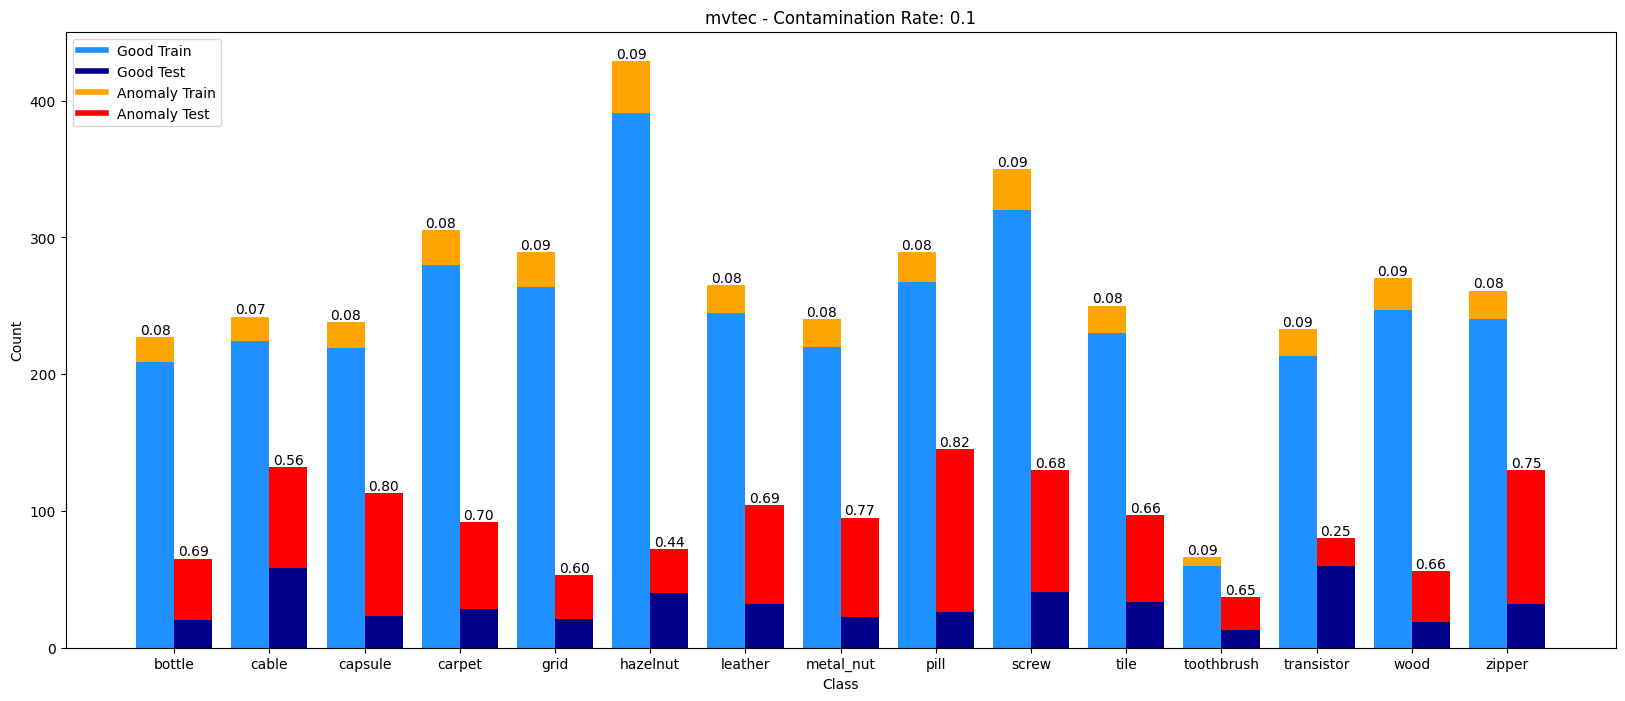

In [12]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]

    ratios = [anomalies[i] /(good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]
    
    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    res_df=pd.concat([res_df,df_class])
    
    
    # fig, ax = plt.subplots(figsize=(10, 6))
    # bar_width = 0.5
    # bar1 = np.arange(len(categories))
    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')
    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()
    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')
    # plt.show()
    
plot_allbars(res_df,args)

MVTEC LOCO

In [13]:
# loco
anomaly_categories = {
    'breakfast_box': ['logical_anomalies', 'structural_anomalies'],
    'juice_bottle': ['logical_anomalies', 'structural_anomalies'],
    'pushpins': ['logical_anomalies', 'structural_anomalies'],
    'screw_bag': ['logical_anomalies', 'structural_anomalies'],
    'splicing_connectors': ['logical_anomalies', 'structural_anomalies'],
}

#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self,category='breakfast_box'):
        self.exp_name = "Exp_20_02_24"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/'
        self.data_category = category
        self.data_ratio = 0.1
        self.batch_size = 20
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'mvtec_loco'
        self.mode = 'mvtec_loco'
        self.results_dir = 'results'
        self.development = True
               
args = TrainOptions()
torch.manual_seed(args.seed)

print(args.data_category)

try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
    print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
    
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)
dataiter = iter(train_dataloader)

try:
    images, _ = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")


breakfast_box
Configuration file for mvtec_loco found. Proceeding with parameters.
category: breakfast_box, normals train:  351, anomalies test: 173, normal test: 102
anomalies test total:     {'logical_anomalies': 83, 'structural_anomalies': 90}
anomalies test sampled:   {'logical_anomalies': 19, 'structural_anomalies': 21}
anomalies test remaining: {'logical_anomalies': 64, 'structural_anomalies': 69}
('/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/328.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/292.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/205.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/262.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/149.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/273.png', '/home/bule/projects/dataset

Configuration file for mvtec_loco found. Proceeding with parameters.
category: breakfast_box, normals train:  351, anomalies test: 173, normal test: 102
anomalies test total:     {'logical_anomalies': 83, 'structural_anomalies': 90}
anomalies test sampled:   {'logical_anomalies': 19, 'structural_anomalies': 21}
anomalies test remaining: {'logical_anomalies': 64, 'structural_anomalies': 69}
Configuration file for mvtec_loco found. Proceeding with parameters.
category: juice_bottle, normals train:  335, anomalies test: 236, normal test: 94
anomalies test total:     {'logical_anomalies': 142, 'structural_anomalies': 94}
anomalies test sampled:   {'logical_anomalies': 22, 'structural_anomalies': 15}
anomalies test remaining: {'logical_anomalies': 120, 'structural_anomalies': 79}
Configuration file for mvtec_loco found. Proceeding with parameters.
category: pushpins, normals train:  372, anomalies test: 172, normal test: 138
anomalies test total:     {'logical_anomalies': 91, 'structural_an

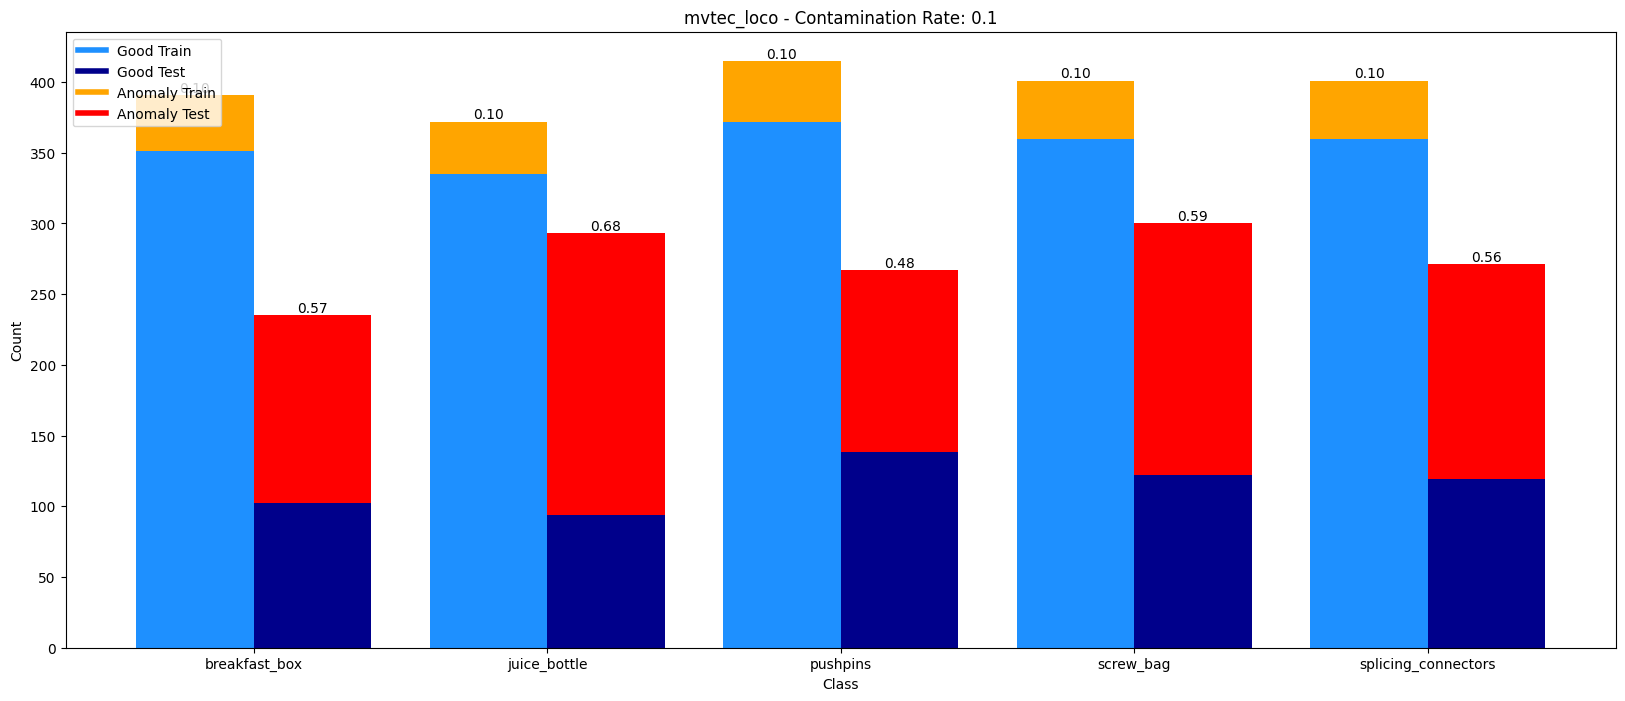

In [14]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
    
        
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec_loco(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]

    ratios = [anomalies[i] / (good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]
    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    res_df=pd.concat([res_df,df_class])
    # fig, ax = plt.subplots(figsize=(10, 6))

    # bar_width = 0.5
    # bar1 = np.arange(len(categories))

    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')

    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()


    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')


    # plt.show()
    
plot_allbars(res_df,args)

BEANTEC

In [15]:
# beantec
anomaly_categories={
    "01": ["ko"],
    "02": ["ko"],
    "03": ["ko"]}


#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self,category='01'):
        self.exp_name = "Exp_19_06_24"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/BTech_Dataset_transformed'
        self.data_category = category
        self.batch_size = 20
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.data_ratio = 1.0
        self.test_seed = 400    
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'beantec'
        self.mode = 'beantec'
        self.results_dir = 'results'
        self.development = True
               
args = TrainOptions()
torch.manual_seed(args.seed)


try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)
dataiter = iter(train_dataloader)

try:
    images, _ = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")




category: 01, normals train:  400, anomalies test: 49, normal test: 21
anomalies test total:     {'ko': 49}
anomalies test sampled:   {'ko': 40}
anomalies test remaining: {'ko': 9}
('/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0059.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/test/ko/0047.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0202.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0010.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/test/ko/0043.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0150.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0266.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0033.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0003.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/test/ko/0035.bmp', '/home/bule/projects/datasets/B

Configuration file for beantec found. Proceeding with parameters.
category: 01, normals train:  400, anomalies test: 49, normal test: 21
anomalies test total:     {'ko': 49}
anomalies test sampled:   {'ko': 40}
anomalies test remaining: {'ko': 9}
Configuration file for beantec found. Proceeding with parameters.
category: 02, normals train:  399, anomalies test: 200, normal test: 30
anomalies test total:     {'ko': 200}
anomalies test sampled:   {'ko': 39}
anomalies test remaining: {'ko': 161}
Configuration file for beantec found. Proceeding with parameters.
category: 03, normals train:  292, anomalies test: 82, normal test: 800
anomalies test total:     {'ko': 82}
anomalies test sampled:   {'ko': 29}
anomalies test remaining: {'ko': 53}
0 Train
1 Test


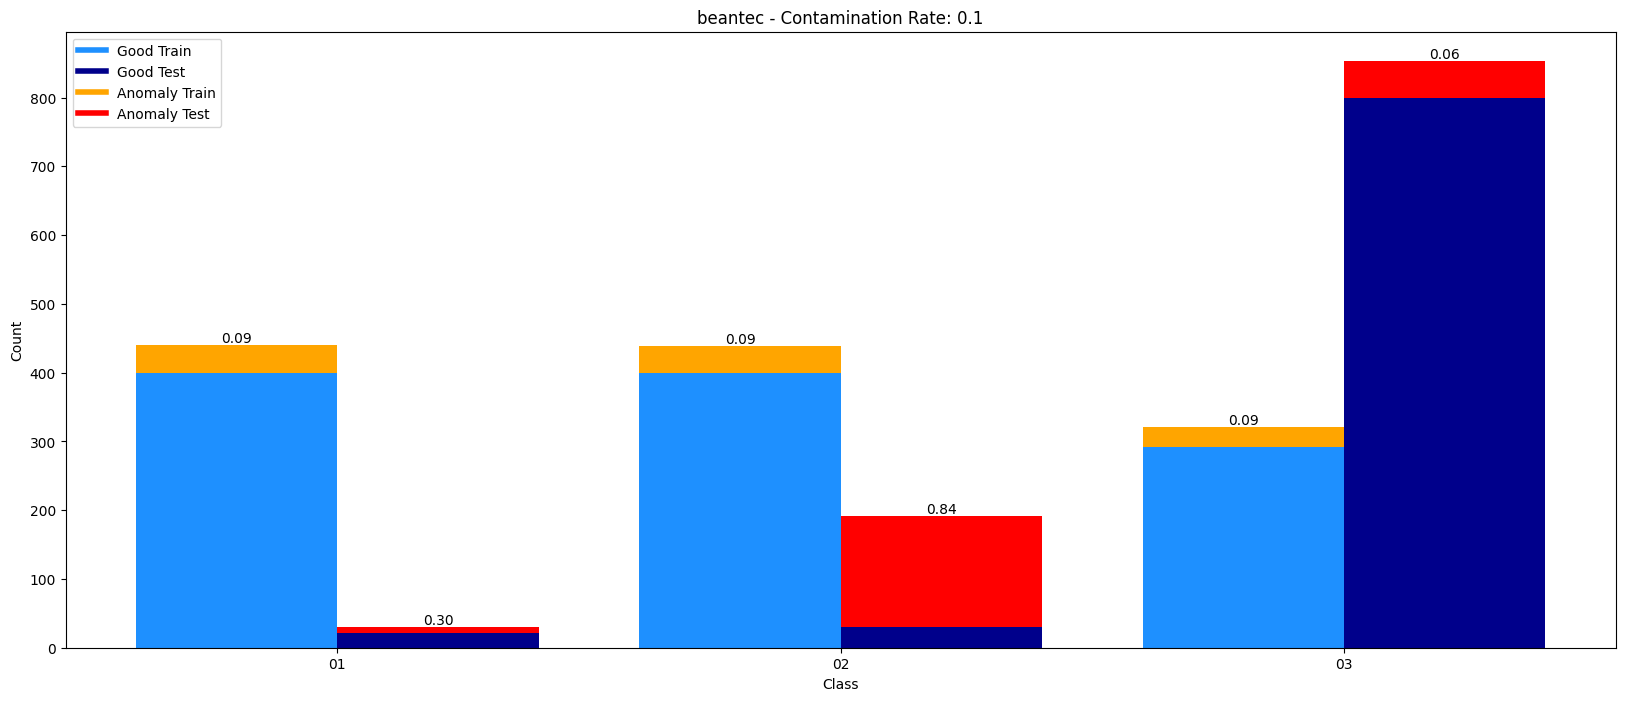

In [16]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
    
        
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_beantec(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]

    ratios = [anomalies[i] / (good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]



    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    
    res_df=pd.concat([res_df,df_class])
    
    # fig, ax = plt.subplots(figsize=(10, 6))

    # bar_width = 0.5
    # bar1 = np.arange(len(categories))

    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')

    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()


    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')



plot_allbars(res_df,args)

VISA

In [17]:
# visa
anomaly_categories={
    "candle": ["Anomaly"],
    "capsules": ["Anomaly"],
    "cashew": ["Anomaly"],
    "chewinggum":["Anomaly"],
    "fryum": ["Anomaly"],
    "macaroni1": ["Anomaly"],
    "macaroni2": ["Anomaly"],
    "pcb1":["Anomaly"],
    "pcb2":["Anomaly"],
    "pcb3":["Anomaly"],
    "pcb4": ["Anomaly"],
    "pype_fryum": ["Anomaly"]
    }



#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self,category='capsules'):
        self.exp_name = "Exp_19_06_24"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.test_seed = 400
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/VisA'
        self.data_category = category
        self.batch_size = 2
        self.data_ratio = 1.0
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'visa'
        self.mode = 'visa'
        self.results_dir = 'results'
        self.development = True
               
args = TrainOptions()
torch.manual_seed(args.seed)


try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)

dataiter = iter(train_dataloader)

try:
    images, _ = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")
    
dataiter_test = iter(test_dataloader)   

try:
    filename, img, ground_truth, _ = next(dataiter_test) 
    print(filename)# Use next() function to get the next batch
    print(img.size())
    print(ground_truth.max(),ground_truth.min())
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")
    
    

category: capsules, normals train:  542, anomalies test: 100, normal test: 60
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 54}
anomalies test remaining: {'Anomaly': 46}


('/home/bule/projects/datasets/VisA/capsules/Data/Images/Normal/573.JPG', '/home/bule/projects/datasets/VisA/capsules/Data/Images/Normal/474.JPG')
anomalies per batch: {'Anomaly': 0}
('/home/bule/projects/datasets/VisA/capsules/Data/Images/Normal/062.JPG', '/home/bule/projects/datasets/VisA/capsules/Data/Images/Normal/240.JPG')
torch.Size([2, 3, 256, 256])
tensor(0.) tensor(0.)
anomalies per batch: {'Anomaly': 0}


category: candle, normals train:  900, anomalies test: 100, normal test: 100
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 90}
anomalies test remaining: {'Anomaly': 10}
category: capsules, normals train:  542, anomalies test: 100, normal test: 60
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 54}
anomalies test remaining: {'Anomaly': 46}
category: cashew, normals train:  450, anomalies test: 100, normal test: 50
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 45}
anomalies test remaining: {'Anomaly': 55}
category: chewinggum, normals train:  453, anomalies test: 100, normal test: 50
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 45}
anomalies test remaining: {'Anomaly': 55}
category: fryum, normals train:  450, anomalies test: 100, normal test: 50
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 45}
anomalies test remain

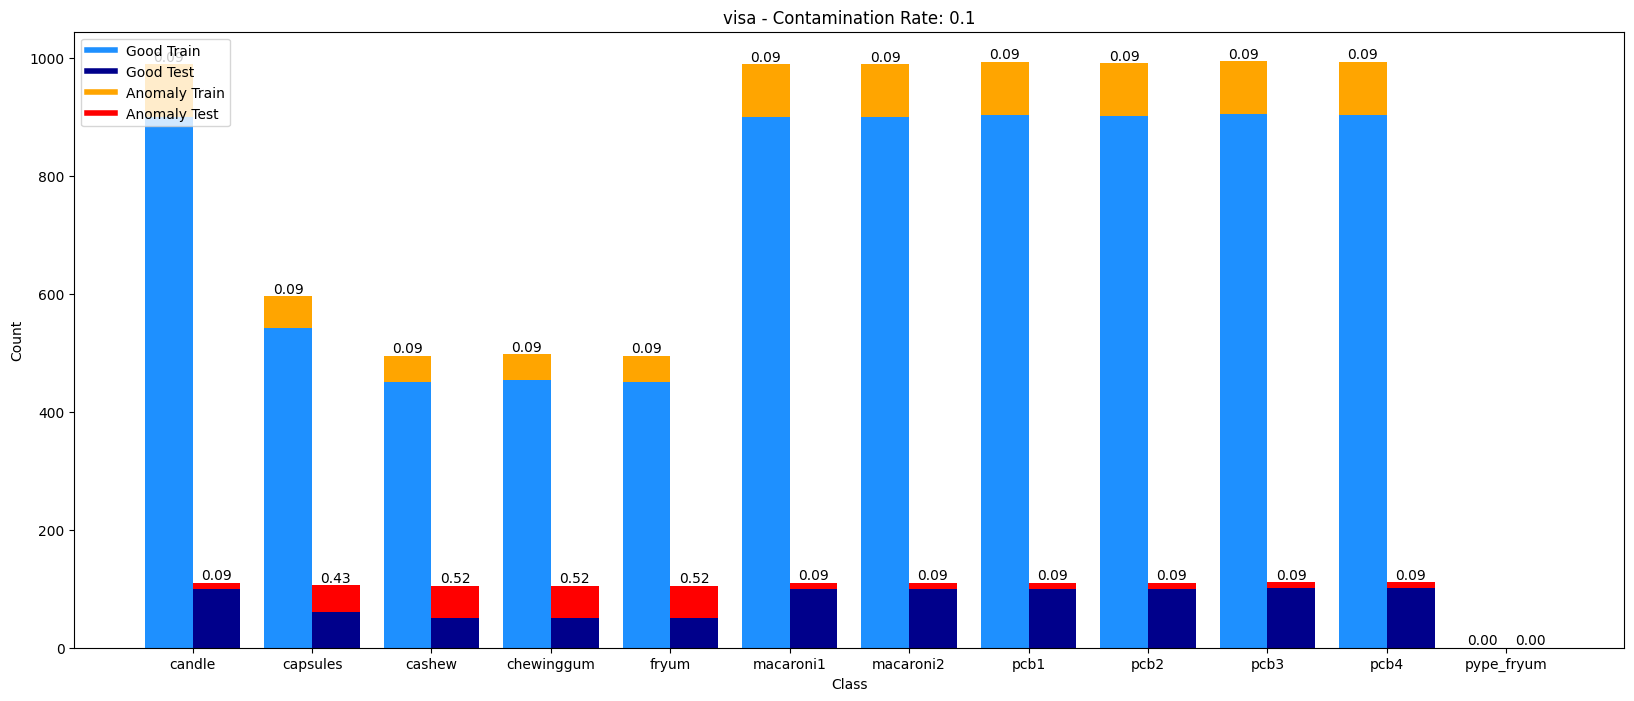

In [18]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        # print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_visa(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]
    ratios = [anomalies[i] / (good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]

    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    res_df=pd.concat([res_df,df_class])

    # fig, ax = plt.subplots(figsize=(10, 6))
    # bar_width = 0.5
    # bar1 = np.arange(len(categories))

    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')

    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()
    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')

    # plt.show()
    
plot_allbars(res_df,args)